In [55]:
#Import the appropriate libraries
import re
import pandas as pd
import numpy as np
import string
import nltk
import warnings
import matplotlib.pyplot as plot
import seaborn

In [56]:
# from google.colab import drive
# drive.mount('/content/drive')

In [57]:
#Initial Setup & import dataset
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

test = pd.read_csv('test_tweets_anuFYb8.csv')
train = pd.read_csv('train_E6oV3lV.csv')

# Concatenate train and test DataFrames
combined = pd.concat([train, test], ignore_index=True)

In [58]:
#Preprocess Tweets: Remove items from a tweet that do not add significance to the sentiment.
#1. Remove @usernames
#2. Remove special characters, punctuation, and numbers
#3. Remove words less than 4 characters in length

In [59]:
#Helper function to remove sub-strings from an input string
def removeSubString(input, subString):
    matchesList = re.findall(subString, input)

    for match in matchesList:
        input = re.sub(match, '', input)

    return input

In [60]:
#1. Remove @usernames
#"@[\w]*" is any word starting with an @ symbol. This line of code will remove all usernames from tweets, as it is
#not important in determing the sentiment of a tweet.
combined['processed_tweet'] = np.vectorize(removeSubString)(combined['tweet'], "@[\w]*")

In [61]:
#2. Remove numbers, punctuation, and special characters from the tweets.
combined['processed_tweet'] = combined['processed_tweet'].str.replace("[^a-zA-Z#]", " ")

<ipython-input-61-cdc6b517df80>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  combined['processed_tweet'] = combined['processed_tweet'].str.replace("[^a-zA-Z#]", " ")


In [62]:
#3. Remove words with less than 4 letters as they do not add significance to the tweet.
combined['processed_tweet'] = combined['processed_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [63]:
#Processed tweets:
combined.head()

,id,label,tweet,processed_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [64]:
#Tokenize Tweets: Seperate the Strings (tweets) into individual words
tokenized_tweet = combined['processed_tweet'].apply(lambda x: x.split())

In [65]:
#Stemming: Removing suffixes from words
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: processed_tweet, dtype: object

In [66]:

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combined['processed_tweet'] = tokenized_tweet

In [67]:
#Gather all words
all_words = ' '.join([text for text in combined['processed_tweet']])

#Gather all the words in the negative tweets
negative_words = ' '.join([text for text in combined['processed_tweet'][combined['label'] == 1]])

#Gather all the words in the regular tweets
regular_words = ' '.join([text for text in combined['processed_tweet'][combined['label'] == 0]])

In [68]:
negative_words[0]

'#'

In [69]:
#Helper function to get hashtags from a tweet by taking words after a "#" symbol.
def getHashtags(tweets):
    hashtags = []
    for i in tweets:
        hashtag = re.findall(r"#(\w+)",i)
        hashtags.append(hashtag)
    return hashtags

In [70]:
#Create two lists, one for hashtags in the negative tweets and one for the positive tweets.
Negative_Hashtags = getHashtags(combined['processed_tweet'][combined['label'] == 1])
Negative_Hashtags = sum(Negative_Hashtags, [])

Regular_Hashtags = getHashtags(combined['processed_tweet'][combined['label'] == 0])
Regular_Hashtags = sum(Regular_Hashtags, [])

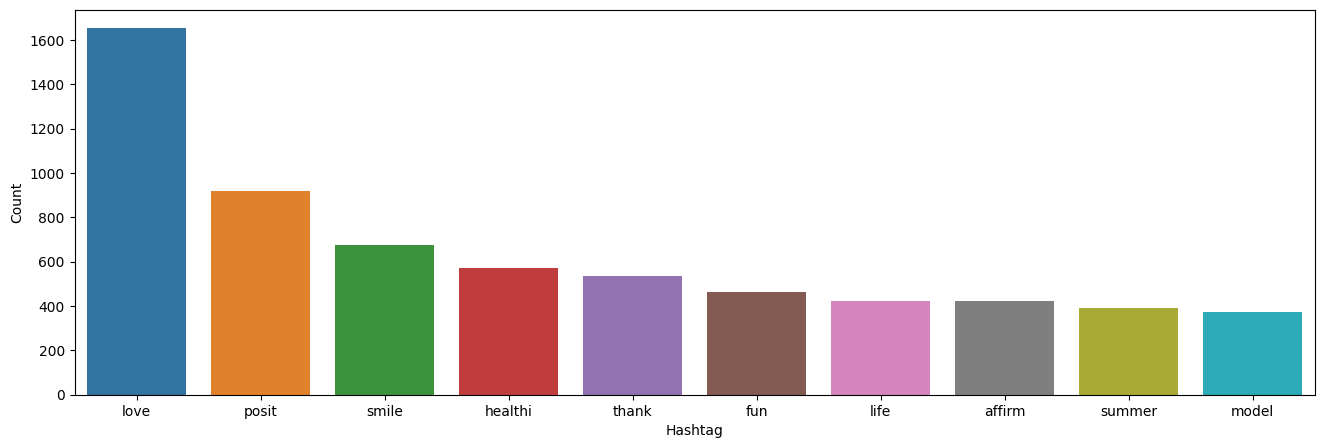

In [71]:
#A figure to display the hashtags sorted by usage.
a = nltk.FreqDist(Regular_Hashtags)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns="Count", n = 10)
plot.figure(figsize=(16,5))
ax = seaborn.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plot.show()

In [92]:
#Bag-of-words technique is used to meaningfully convey the text numerically.
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combined['processed_tweet'])

import joblib

joblib.dump(bow_vectorizer, 'countt_vectorizer.pkl')
# Load the fitted CountVectorizer
bow_vectorizer = joblib.load('countt_vectorizer.pkl')


In [73]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score
# import numpy as np
# import joblib

# train_bow = bow[:31962,:]
# test_biw = bow[31962:,:]
# xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

# lreg = LogisticRegression()
# lreg.fit(xtrain_bow, ytrain)  # training the model
# joblib.dump(lreg, 'trained_model.pkl')

# # Predict on the validation set
# prediction = lreg.predict_proba(xvalid_bow)

# # Modify the threshold to classify as neutral
# threshold_positive >= 0.3   # Adjust this threshold as needed
# threshold_negative < 0.3  # Adjust this threshold as needed
# threshold_negative == 0

# # Classify as positive, negative, or neutral
# prediction_positive = prediction[:, 1] >= threshold_positive
# prediction_negative = prediction[:, 1] <= threshold_negative
# prediction_neutral = prediction[:, 1] <= threshold_negative

# # Convert to integers
# prediction_positive = prediction_positive.astype(int)
# prediction_negative = prediction_negative.astype(int)
# prediction_neutral = prediction_neutral.astype(int)

# # Calculate F1 scores for positive, negative, and neutral
# f1_score_positive = f1_score(yvalid, prediction_positive)
# f1_score_negative = f1_score(yvalid, prediction_negative)
# f1_score_neutral = f1_score(yvalid, prediction_neutral)

# print(f"F1 Score (Positive): {f1_score_positive}")
# print(f"F1 Score (Negative): {f1_score_negative}")
# print(f"F1 Score (Neutral): {f1_score_neutral}")


In [93]:
#Use a logistic regression model on the Bag-of-words.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import joblib
train_bow = bow[:31962,:]
test_biw = bow[31962:,:]
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model
joblib.dump(lreg, 'trained_model.pkl')
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(int)
f1_score(yvalid, prediction_int) # calculating f1 score

0.5303408146300915

In [90]:
prediction > 1

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [87]:
# bow_vectorizer = joblib.load('count_vectorizer.pkl')
# model = joblib.load('trained_model.pkl')

# # Create a function to preprocess and predict sentiment
# def preprocess_text(text):
#     text = re.sub(r'[^a-zA-Z]', ' ', text)
#     text = ' '.join(text.split())
#     return text.lower()

# def predict_sentiment(input_text):
#     # Preprocess the user input
#     preprocessed_input = preprocess_text(input_text)

#     # Use the loaded CountVectorizer to transform the input text
#     preprocessed_input_bow = bow_vectorizer.transform([preprocessed_input])

#     # Use the loaded model to predict sentiment
#     prediction = model.predict(preprocessed_input_bow)

#     # Adjust the threshold to classify as neutral
#     threshold_positive = 0.4  # Adjust this threshold as needed
#     threshold_negative = 0.4  # Adjust this threshold as needed

#     if prediction >= threshold_positive:
#         return "Positive Sentiment"
#     elif prediction <= threshold_negative:
#         return "Negative Sentiment"
#     else:
#         return "Neutral Sentiment"

# # Get user input
# user_input = input("Enter a sentence: ")

# # Predict the sentiment
# sentiment = predict_sentiment(user_input)
# print(f"Predicted Sentiment: {sentiment}")


Enter a sentence: i love you
Predicted Sentiment: Non-Racist/Non-Sexist Sentiment


In [102]:
# import joblib
# import re
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.linear_model import LogisticRegression

# # Load the trained model
# model = joblib.load('trained_model.pkl')

# # Load the fitted CountVectorizer
# bow_vectorizer = joblib.load('countt_vectorizer.pkl')

# # Create a function to preprocess and predict sentiment
# def preprocess_text(text):
#     text = re.sub(r'[^a-zA-Z]', ' ', text)
#     text = ' '.join(text.split())
#     return text.lower()

# def predict_sentiment(input_text):
#     # Preprocess the user input
#     preprocessed_input = preprocess_text(input_text)

#     # Use the loaded CountVectorizer to transform the input text
#     preprocessed_input_bow = bow_vectorizer.transform([preprocessed_input])

#     # Use the loaded model to predict sentiment
#     prediction = model.predict(preprocessed_input_bow)

#     return "Racist/Sexist Sentiment" if prediction == 1 else "Non-Racist/Non-Sexist Sentiment"

# # Get user input
# user_input = input("Enter a sentence: ")

# # Predict the sentiment
# sentiment = predict_sentiment(user_input)
# print(f"Predicted Sentiment: {sentiment}")


Enter a sentence: IF YOU'RE NOT WHITE YOU'RE NOT WELCOME!
Predicted Sentiment: Racist/Sexist Sentiment


In [104]:
import tkinter as tk
from tkinter import messagebox
import joblib
import matplotlib
matplotlib.use('Agg')

# Load the CountVectorizer and trained model
bow_vectorizer = joblib.load('count_vectorizer.pkl')
model = joblib.load('trained_model.pkl')

# Create a function to preprocess and predict sentiment
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = ' '.join(text.split())
    return text.lower()

def predict_sentiment(input_text):
    preprocessed_input = preprocess_text(input_text)
    preprocessed_input_bow = bow_vectorizer.transform([preprocessed_input])
    prediction = model.predict(preprocessed_input_bow)

    threshold_positive = 0.4  # Adjust as needed
    threshold_negative = 0.4  # Adjust as needed

    if prediction >= threshold_positive:
        return "Positive Sentiment"
    elif prediction <= threshold_negative:
        return "Negative Sentiment"
    else:
        return "Neutral Sentiment"

# Create a function to handle the button click event
def analyze_sentiment():
    user_input = text_entry.get("1.0", "end-1c")  # Get the user's input from the text box
    sentiment = predict_sentiment(user_input)
    result_label.config(text=f"Predicted Sentiment: {sentiment}")

# Create the GUI window
root = tk.Tk()
root.title("Sentiment Analysis")

# Create a text entry field
text_entry = tk.Text(root, height=10, width=40)
text_entry.pack()

# Create an analyze button
analyze_button = tk.Button(root, text="Analyze Sentiment", command=analyze_sentiment)
analyze_button.pack()

# Create a label to display the result
result_label = tk.Label(root, text="")
result_label.pack()

# Start the GUI application
root.mainloop()


TclError: ignored